Import necessary libraries

In [1]:
import torch
import torch.nn as nn
from data import Caltech101Dataset, TransformsHolder, extract_tar
from torch.utils.data import DataLoader
from utils import create_optimizer_with_exponential_lrs, display_image_grid
import torch.optim as optim
import numpy as np
from torch.utils.data import Subset
from tqdm import tqdm
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

If the environment is the google colab, use
    !gdown 137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp

otherwise, visit the link below, and download the dataset manually.

prepare train and valid data loaders with the ratio 8:2.

In [2]:
# link : https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp 
tar_path = "101_ObjectCategories.tar.gz"
extract_path = "caltech101"

extract_tar(tar_path, extract_path=extract_path)

# Instantiate the dataset with the directory and the transform
dataset = Caltech101Dataset(extract_path, transform=TransformsHolder.transform_default)

# Create indices for the split
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))  # 20% for validation

np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

Directory 'caltech101' already exists. Extraction skipped.


## Model

Load the pretrained model.

Replace the output fc layer for the new task.

In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(512, 102, bias=True)

model = model.to(device)
model.train()


Using cache found in C:\Users\sisun/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Extra Setup

We use CrossEntropyLoss for the classification task.

While early layers are corresponding to the general features, later layers are to the more specific features.
To preserve the general features, we apply different learning rates depending on the layer.

In [ ]:
criterion = nn.CrossEntropyLoss()
min_lr, max_lr, num_layers, opti_const = 1e-5, 1e-3, 4, optim.Adam
opti_kwag = None
optimizer = create_optimizer_with_exponential_lrs(model, min_lr, max_lr, num_layers, opti_const, opti_kwag=None)

for i, param_group in enumerate(optimizer.param_groups):
    print(f"Layer {i}: Learning Rate: {param_group['lr']}")

## Train

Train up to 15 epochs with early stopping patience 3.
Update the model checkpoint whenever the validation loss is decreased.

In [ ]:

best_val_loss = float('inf')
epochs = 15
patience = 3
epochs_since_improvement = 0

os.makedirs("models", exist_ok=True)
model_save_path = "models/model_checkpoint.pth"

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    progress_bar = tqdm(train_loader)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix(
            train_loss = loss.item()
        )

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    progress_bar = tqdm(val_loader)
    
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            progress_bar.set_postfix(
                val_loss = loss.item()
            )

    val_loss /= len(val_loader)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_since_improvement = 0

        # Save the model checkpoint
        torch.save(model.state_dict(), model_save_path)
        print(f'Epoch {epoch+1}: Validation loss improved, saving model to {model_save_path}')

    else:
        epochs_since_improvement += 1

    if epochs_since_improvement == patience:
        print(f'Early stopping triggered after {epoch + 1} epochs!')
        break

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}')


100%|██████████| 15/15 [00:06<00:00,  2.16it/s, val_loss=0.288]


Epoch 1: Validation loss improved, saving model to models/model_checkpoint.pth
Epoch [1/15], Loss: 0.9981, Val Loss: 0.3606


100%|██████████| 15/15 [00:04<00:00,  3.74it/s, val_loss=0.132]


Epoch 2: Validation loss improved, saving model to models/model_checkpoint.pth
Epoch [2/15], Loss: 0.1284, Val Loss: 0.3060


100%|██████████| 15/15 [00:05<00:00,  2.77it/s, val_loss=0.12] 


Epoch 3: Validation loss improved, saving model to models/model_checkpoint.pth
Epoch [3/15], Loss: 0.0426, Val Loss: 0.2639


100%|██████████| 15/15 [00:04<00:00,  3.43it/s, val_loss=0.117] 


Epoch 4: Validation loss improved, saving model to models/model_checkpoint.pth
Epoch [4/15], Loss: 0.0149, Val Loss: 0.2218


100%|██████████| 15/15 [00:04<00:00,  3.55it/s, val_loss=0.0732]


Epoch 5: Validation loss improved, saving model to models/model_checkpoint.pth
Epoch [5/15], Loss: 0.0096, Val Loss: 0.2080


100%|██████████| 15/15 [00:06<00:00,  2.46it/s, val_loss=0.252]


Epoch [6/15], Loss: 0.0206, Val Loss: 0.2523


100%|██████████| 15/15 [00:03<00:00,  3.82it/s, val_loss=0.407]


Epoch [7/15], Loss: 0.0249, Val Loss: 0.3576


100%|██████████| 15/15 [00:05<00:00,  2.90it/s, val_loss=0.547]

Early stopping triggered after 8 epochs!


## Validation

Check the performance of the model with the validation dataset.

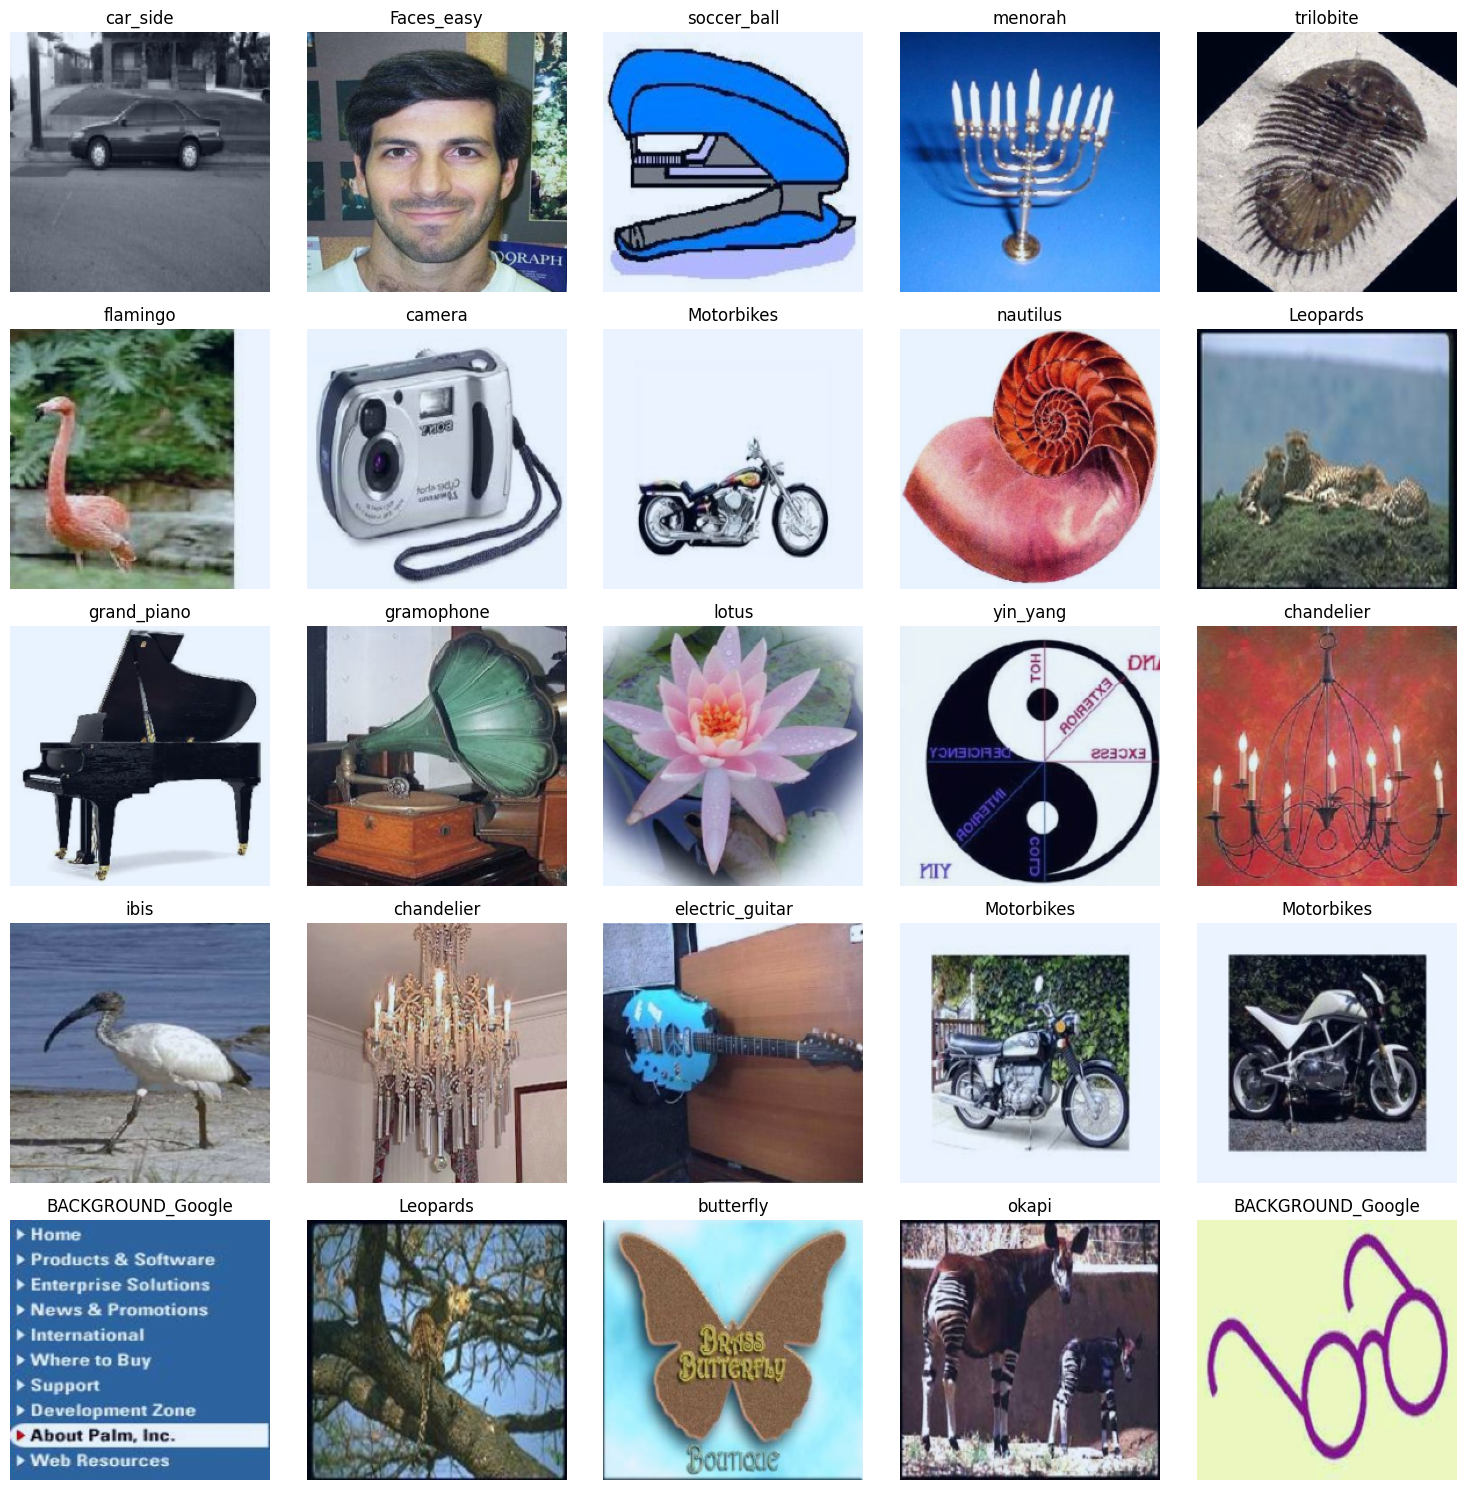

In [ ]:
display_image_grid(dataset, val_loader, model, device, grid_size=5)
